### LINCI FELICITA P 
### CB.SC.I5DAS18022

### DENOISING IMAGES USING AUTOENCODER

### Importing all the necessary libraries

In [ ]:
import os
import cv2
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

### Reading the data set

In [ ]:
import zipfile  # unziping 
import glob  # finding image paths
import numpy as np  # creating numpy arrays
from skimage.io import imread  # reading images
from skimage.transform import resize  # resizing images
# 1. Unzip images
path = '/content/dataset.zip'
with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall('/content/image_data')

### Converting the images from .tiff to .jpeg 

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

os.makedirs('/content/jpg_data')

for files in  os.listdir("/content/image_data/shuffled"):
    im = Image.open('/content/image_data/shuffled/'+str(files))
    im.save('/content/jpg_data/'+str(files).replace(".tiff","")+'.jpeg')

### Resizing all images to the same size

In [ ]:
os.makedirs('/content/processed_img')

for fil in  os.listdir("/content/jpg_data"):
    img=cv2.imread('/content/jpg_data/'+str(fil))
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img2=255-img
    img2=cv2.resize(img2, (224, 224))
    cv2.imwrite("/content/processed_img/"+str(fil), img2)

### Visualizing Salt and pepper noise

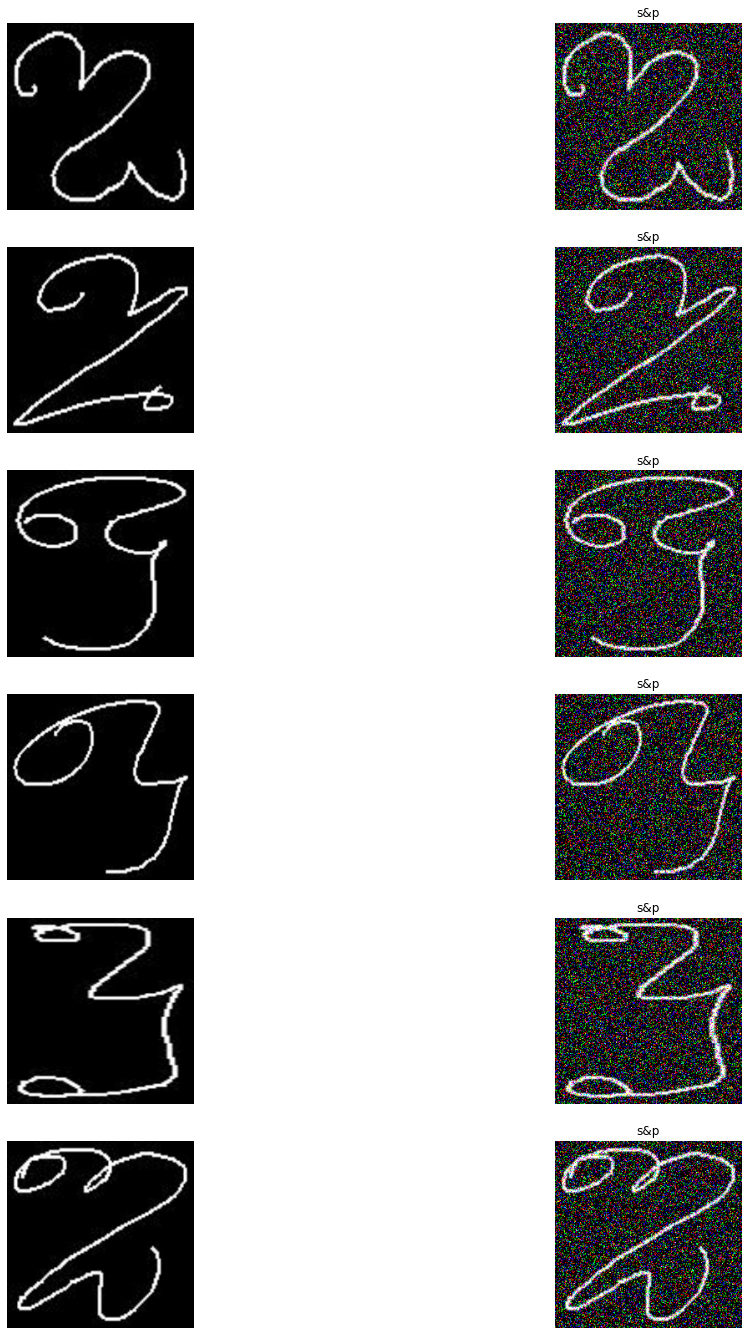

In [ ]:
import skimage
def plotnoise(img, mode, r, c, i):
    plt.subplot(r,c,i)
    if mode is not None:
        gimg = skimage.util.random_noise(img, mode=mode, amount=0.25, salt_vs_pepper= 0.5)
        plt.imshow(gimg)
    else:
        plt.imshow(img)
    plt.title(mode)
    plt.axis("off")

plt.figure(figsize=(18,24))
r=6
c=2
j = 1
k = 0
for imgs in os.listdir('/content/processed_img'):
  if k < 6:
    img = skimage.io.imread('/content/processed_img/'+str(imgs))/255.0
    plotnoise(img, None , r,c,j)
    plotnoise(img, "s&p", r,c,j+1)
    j=j+2
    k=k+1
  else:
    break
plt.show()

### Adding the original images to an array

In [ ]:
images = []
for filename in os.listdir("/content/processed_img/"):
  img = cv2.imread("/content/processed_img/"+filename,0)/255
  img=cv2.resize(img,(128,128))
  img.shape=(128,128,1)
  images.append(img) 
images_1=np.array(images)

### Adding noise to the images

In [ ]:
import skimage
import matplotlib
os.makedirs('/content/snp01_img')
for imgs in os.listdir('/content/processed_img'):
  img = skimage.io.imread('/content/processed_img/'+str(imgs))/255.0  
  simg = skimage.util.random_noise(img, mode='s&p', amount=0.25, salt_vs_pepper= 0.5)
  matplotlib.image.imsave("/content/snp01_img/"+str(imgs), simg) 


### converting the noisy images to an array

In [ ]:
snp = []
for filename in os.listdir("/content/snp01_img/"):
  img = cv2.imread("/content/snp01_img/"+filename,0)/255
  img=cv2.resize(img,(128,128))
  img.shape=(128,128,1)
  snp.append(img) 
snp_1=np.array(snp)

### Train-Test split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(snp_1,images_1,test_size=0.33, random_state=42) 

In [ ]:
print("Size of train data is:",(X_train).shape) 
print("Size of test data is:",(X_test).shape) 

Size of train data is: (905, 128, 128, 1)
Size of test data is: (446, 128, 128, 1)


In [ ]:
len(y_train)

905

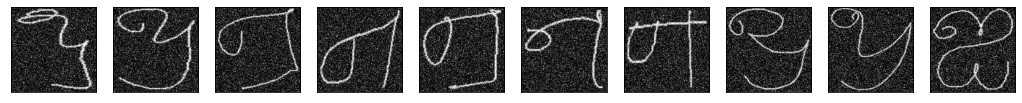

In [ ]:
n = 10
plt.figure(figsize=(18,24))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(X_test[i].reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


### Model development

In [ ]:

import keras
from keras import layers

input_img = keras.Input(shape=(128,128, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x1 = layers.MaxPooling2D((2, 2), padding='same')(x)
x2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x1)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x2)

# At this point the representation is (7, 7, 32)

x3 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x4 = layers.UpSampling2D((2, 2))(x3)
x5 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x4)
x6 = layers.UpSampling2D((2, 2))(x5)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x6)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        2320  

In [ ]:
history=autoencoder.fit(X_train, y_train, epochs=20, batch_size=100, validation_data=(X_test, y_test),verbose=1)

Epoch 1/20
10/10 [==============================] - 38s 4s/step - loss: 0.5838 - val_loss: 0.3507
Epoch 2/20
10/10 [==============================] - 36s 4s/step - loss: 0.3531 - val_loss: 0.3277
Epoch 3/20
10/10 [==============================] - 35s 4s/step - loss: 0.3132 - val_loss: 0.3035
Epoch 4/20
10/10 [==============================] - 36s 4s/step - loss: 0.2904 - val_loss: 0.2798
Epoch 5/20
10/10 [==============================] - 36s 4s/step - loss: 0.2677 - val_loss: 0.2568
Epoch 6/20
10/10 [==============================] - 37s 4s/step - loss: 0.2443 - val_loss: 0.2304
Epoch 7/20
10/10 [==============================] - 36s 4s/step - loss: 0.2130 - val_loss: 0.1920
Epoch 8/20
10/10 [==============================] - 36s 4s/step - loss: 0.1725 - val_loss: 0.1530
Epoch 9/20
10/10 [==============================] - 37s 4s/step - loss: 0.1420 - val_loss: 0.1352
Epoch 10/20
10/10 [==============================] - 37s 4s/step - loss: 0.1295 - val_loss: 0.1266
Epoch 11/20
10/10 [

### Predicting the model

In [ ]:
predict = autoencoder.predict(y_test) 

### Noisy image

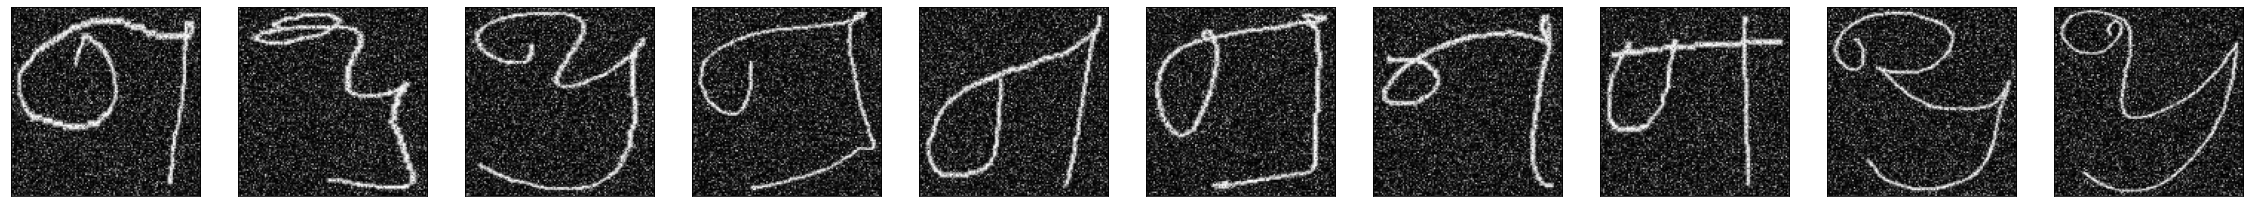

In [ ]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(X_test[i].reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Original image

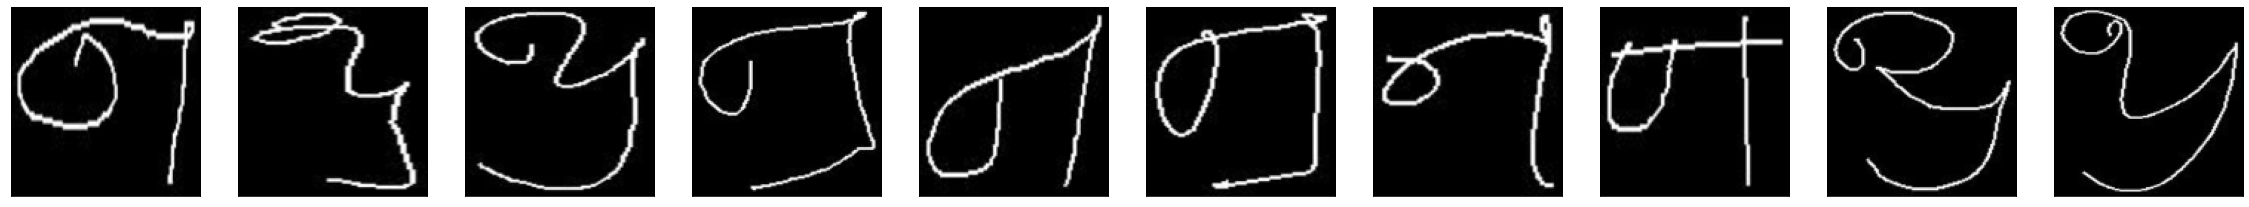

In [ ]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(y_test[i].reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Predicted - denoised image

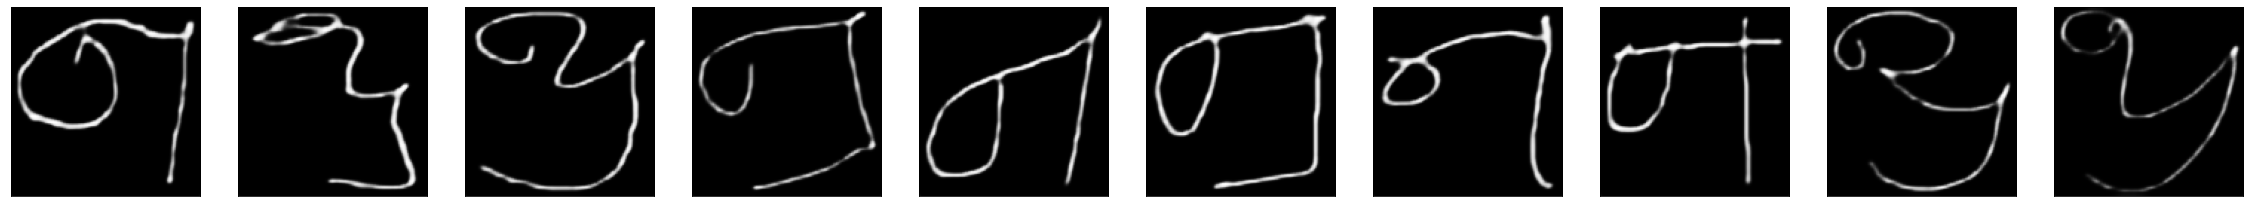

In [ ]:
plt.figure(figsize=(40, 48))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(predict[i].reshape(128,128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

### Training and validation loss

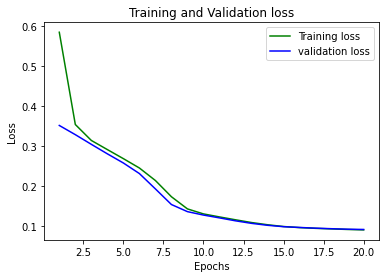

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,21)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()